In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and pre-processing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
X_train.shape, y_train.shape,type(X_train), type(y_train)

((60000, 28, 28), (60000,), numpy.ndarray, numpy.ndarray)

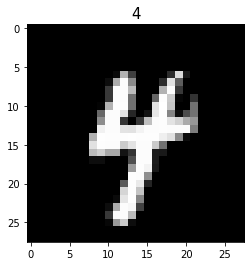

In [5]:
i = np.random.randint(0, 60000)
plt.imshow(X_train[i], cmap = "gray")
plt.title(y_train[i] , fontsize = 15)
plt.show()

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train.shape

(60000, 28, 28, 1)

In [8]:
# X_train = X_train / 255

X_train = (X_train - 127.5) / 127.5
X_train.max(), X_train.min()

(1.0, -1.0)

In [9]:
buffer_size = 60000
batch_size = 256

In [10]:
buffer_size / batch_size

234.375

In [11]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [14]:
# 235 tane 256 lık var !!!
i = 0
for _ in X_train:
    print()
    i+=1
i

235

In [17]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float64>

# Building the generator
- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/

- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
7*7*256

12544

In [25]:
def build_generator():

    network = tf.keras.models.Sequential()

    network.add(tf.keras.layers.Dense(7*7*256, use_bias = False, input_shape = (100, )))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    network.add(tf.keras.layers.Reshape((7,7,256)))

    # 7x7x128
    network.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (5,5),  padding = "same" , use_bias = False))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    # 14x14x64
    network.add(tf.keras.layers.Conv2DTranspose(filters = 64 , kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())

    # 28x28x1
    network.add(tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2),  padding = "same" , use_bias = False ,activation = "tanh"))

    network.summary()

    return network

In [26]:
generator = build_generator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

In [30]:
noise = tf.random.normal([1,100])
np.array(noise).max(),np.array(noise).min()

(2.2905815, -3.094965)

In [31]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

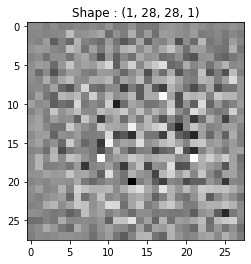

In [35]:
plt.imshow(generated_image[0,:,:,0], cmap = "gray")
plt.title("Shape : {}".format(np.array(generated_image).shape))
plt.show()

# Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [38]:
def build_discriminator():

    network = tf.keras.models.Sequential()

    # 14x14x64
    network.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", input_shape = [28, 28, 1]))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(rate = 0.3))

    # 7x7x128
    network.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding = "same"))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(rate = 0.3))

    network.add(tf.keras.layers.Flatten())
    network.add(tf.keras.layers.Dense(units = 1))

    network.summary()

    return network

In [39]:
discriminator = build_discriminator()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [41]:
discriminator(generated_image , training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00087265]], dtype=float32)>

# Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [42]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [44]:
cross_entropy([1.,1.],[.2,.2],)

<tf.Tensor: shape=(), dtype=float32, numpy=0.59813887>

In [56]:
def discriminator_loss(expected_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [57]:
def generator_loss(fake_output):

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [47]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Training The Model

In [62]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16
bacth_size = 256

@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size , noise_dim])
    with tf.GradientTape() as gen_tape ,tf.GradientTape() as disc_tape:

        generated_image = generator(noise , training = True)

        expected_output = discriminator(images, training = True)
        fake_output = discriminator(generated_image, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [59]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])
test_images.shape

TensorShape([16, 100])

In [64]:
def train(dataset, epochs , test_images):

    for epoch in range(epochs):
        for image_batch in dataset:

            #print(image_batch.shape)
            train_steps(image_batch)

        print("Epoch : ", epoch + 1)
        generated_images = generator(test_images, training = False)
        fig = plt.figure(figsize = (10,10))
        for i in range(generated_images.shape[0]):

            plt.subplot(4,4, i + 1)
            plt.imshow(generated_images[i, :, : ,0 ] * 127.5 + 127.5, cmap = "gray")
            plt.axis("off")

        plt.show()

In [ ]:
train(X_train, epochs , test_images)

# HomeWork And Summary

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [81]:
(X_train, y_train), (_ , _) = tf.keras.datasets.fashion_mnist.load_data()

In [82]:
X_train.shape

(60000, 28, 28)

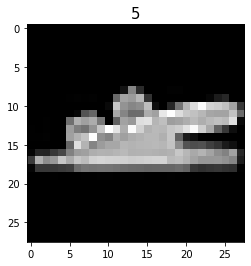

In [83]:
i = np.random.randint(0,60000)
plt.imshow(X_train[i], cmap = "gray")
plt.title(f"{y_train[i]}", fontsize = 15)
plt.show()

In [84]:
X_train = X_train.reshape(X_train.shape[0], 28 , 28, 1).astype("float32")
X_train = (X_train - 127.5) / 127.5
X_train.shape,X_train.max(),X_train.min()

((60000, 28, 28, 1), 1.0, -1.0)

In [85]:
buffer_size = 60000
batch_size = 256

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
# (X_train, y_train), (_ , _) = tf.keras.datasets.fashion_mnist.load_data()

#buffer_size = 60000
#batch_size = 256

#X_train = X_train.reshape(X_train.shape[0], 28 , 28, 1).astype("float32")
#X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

###### Building Generator 

def build_generator():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units = 7*7*256 , use_bias = False , input_shape = (100, )))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7,7,256)))


    model.add(tf.keras.layers.Conv2DTranspose(filters = 128 , kernel_size = (5,5), strides = (1,1), padding = "same" , use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(filters = 64 , kernel_size = (5,5), strides = (2,2) ,padding = "same" , use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(filters = 1 , kernel_size = (5,5), strides = (2,2) ,padding = "same" , use_bias = False, activation = "tanh"))

    #model.summary()

    return model

###### Build Discriminator

def build_discriminator():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", input_shape = [28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.3))

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2,2), padding = "same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 1))

    # model.summary()

    return model

######
generator = build_generator()
discriminator = build_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
######

###### Calculate The Loss

def discriminator_loss(expected_output , fake_output):

    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):

    return cross_entropy(tf.ones_like(fake_output), fake_output)

######
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-04)
discrimator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-04)
######


###### Training The Model

epochs = 100
noise_dim = 100
num_images_to_generate = 16

#buffer_size = 60000
#batch_size = 256

@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim ])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training = True)

        expected_output = discriminator(images, training = True)
        fake_output = discriminator(generated_image, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output,fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discrimator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


test_images = tf.random.normal([num_images_to_generate, noise_dim])

def train(dataset, epochs , test_images):

    for epoch in range(epochs):

        for image_batch in dataset:
            train_steps(image_batch)

        print("Epoch : ", epoch + 1)
        predictions = generator(test_images, training = False)
        fig = plt.figure(figsize = (10,10))
        for i in range(predictions.shape[0]):

            plt.subplot(4,4,i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = "gray")
            plt.axis("off")

        plt.show()

train(X_train, epochs , test_images)